In [2]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns
import sklearn



%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

pd. set_option('display.max_columns', 300) # or 1000.
pd. set_option('display.max_rows', 300) # or 1000.

In [3]:
df = pd.read_csv('Dataset.csv')

### Steps TODO

0. Understanding the problem 

1. Data Reading 
2. Removing the datapoints where the target value is null 
3. Preprocess the data 
4. Train , validation and test split 
5. EDA
6. Feature Engg
7. Feture Selection
8. Modelling 
9. HPT
10. Accuracy 


To Remember --Models only understand numbers 

In [4]:
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Total_Stops,total_duration_min,Price
0,IndiGo,24-03-2019,Banglore,New Delhi,BLR → DEL,22:20,non-stop,170,3897.0
1,Air India,01-05-2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,2 stops,445,7662.0
2,Jet Airways,09-06-2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,2 stops,1140,13882.0
3,IndiGo,12-05-2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,1 stop,325,6218.0
4,IndiGo,01-03-2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,1 stop,285,13302.0
...,...,...,...,...,...,...,...,...,...
13347,Air India,06-06-2019,Kolkata,Banglore,CCU → DEL → BLR,20:30,1 stop,1435,NaN
13348,IndiGo,27-03-2019,Kolkata,Banglore,CCU → BLR,14:20,non-stop,155,NaN
13349,Jet Airways,06-03-2019,Delhi,Cochin,DEL → BOM → COK,21:50,1 stop,395,NaN
13350,Air India,06-03-2019,Delhi,Cochin,DEL → BOM → COK,04:00,1 stop,915,NaN


In [5]:
df.isna().sum()

Airline                  0
Date_of_Journey          0
Source                   0
Destination              0
Route                    1
Dep_Time                 0
Total_Stops              1
total_duration_min       0
Price                 2670
dtype: int64

#### Price is the target column

# Removing the datapoints where the target value is null

In [6]:
main_train = df[df.Price.isnull()==False]
main_test = df[df.Price.isnull()]

In [7]:
#Preprocess the data 
main_train.shape

(10682, 9)

In [8]:
main_train.isna().sum()

Airline               0
Date_of_Journey       0
Source                0
Destination           0
Route                 1
Dep_Time              0
Total_Stops           1
total_duration_min    0
Price                 0
dtype: int64

# Preprocessing

### Null Imputation

In [9]:
main_train[main_train.Route.isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Total_Stops,total_duration_min,Price
9038,Air India,06-05-2019,Delhi,Cochin,NaN,09:45,NaN,1420,7480.0


In [10]:
#Dropping the record contating null value as the Route is MCAR and Total stops is related + single row so doesnot matter much
main_train = main_train[main_train.Route.isnull()==False]

In [11]:
main_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10681 entries, 0 to 10681
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Airline             10681 non-null  object 
 1   Date_of_Journey     10681 non-null  object 
 2   Source              10681 non-null  object 
 3   Destination         10681 non-null  object 
 4   Route               10681 non-null  object 
 5   Dep_Time            10681 non-null  object 
 6   Total_Stops         10681 non-null  object 
 7   total_duration_min  10681 non-null  int64  
 8   Price               10681 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 834.5+ KB


### Date Time Conversion 

In [12]:
main_train['Date_of_Journey'] = pd.to_datetime(main_train['Date_of_Journey'])

### Constant / Duplicate removal

In [13]:
main_train.cov()

,total_duration_min,Price
total_duration_min,2.578775e+05,1.186720e+06
Price,1.186720e+06,2.126202e+07


In [15]:
#other ways to check for variance --> nunique , value_counts

main_train.nunique()

Airline                 12
Date_of_Journey         40
Source                   5
Destination              6
Route                  128
Dep_Time               222
Total_Stops              5
total_duration_min     367
Price                 1870
dtype: int64

In [16]:
# For catagorical columns with relatively low unique value (<= 12) -- looking for value_counts
# if unique count ==1 , constant column 

for col in main_train.columns:
    if main_train[col].nunique()<= 12:
        print(main_train[col].value_counts())
        print('#########################')

Jet Airways                          3849
IndiGo                               2053
Air India                            1750
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64
#########################
Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       696
Chennai      381
Name: Source, dtype: int64
#########################
Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     696
Kolkata       381
Name: Destination, dtype: int64
#########################
1 stop      5625
non-stop    3491
2 stops     1519
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64
#####################

In [17]:
# clubbing Airlines with low occurance in dataset - to ensure model gets max information
main_train['Airline'] = np.where(main_train['Airline'].isin(["Multiple carriers Premium economy",
                                                             "Jet Airways Business",
                                                             "Vistara Premium economy",
                                                             "Trujet"]),"Other Airlines",main_train['Airline'])

In [18]:
#sort values by data as the price is dependent on the jourrney date 
# we only use past data to train the model , hence sorting ensures that while splittig the data only past data is there on the train set

main_train.sort_values(by=['Date_of_Journey'])

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Total_Stops,total_duration_min,Price
3835,SpiceJet,2019-01-03,Kolkata,Banglore,CCU → BLR,09:00,non-stop,150,5515.0
7355,Multiple carriers,2019-01-03,Delhi,Cochin,DEL → BOM → COK,00:20,1 stop,780,29528.0
486,Jet Airways,2019-01-03,Banglore,New Delhi,BLR → BOM → DEL,08:55,1 stop,380,26890.0
3545,Air India,2019-01-03,Banglore,New Delhi,BLR → BOM → IDR → DEL,08:50,2 stops,1580,19372.0
3543,IndiGo,2019-01-03,Banglore,New Delhi,BLR → DEL,10:05,non-stop,175,10067.0
...,...,...,...,...,...,...,...,...,...
4046,Multiple carriers,2019-12-06,Delhi,Cochin,DEL → BOM → COK,09:00,1 stop,615,14848.0
4038,Jet Airways,2019-12-06,Kolkata,Banglore,CCU → BOM → BLR,20:00,1 stop,520,12576.0
4030,Jet Airways,2019-12-06,Delhi,Cochin,DEL → ATQ → BOM → COK,18:20,2 stops,1480,14300.0
4271,Jet Airways,2019-12-06,Delhi,Cochin,DEL → ATQ → BOM → COK,08:10,2 stops,1215,14300.0


# Split Data

In [19]:
# Converting the main_train into X and y so that we can pass it onto train_test_split function

# X --> contains the dataframe without the target i.e price
X = main_train.drop('Price',axis=1)

# y --> contains only the target value 
y = main_train['Price']

In [20]:
#splitting the data first into two part -- doing a 70:30 split i.e 30% data fed to intermediate test data set
from sklearn.model_selection import train_test_split
X_train,X_inter_test,y_train,y_inter_test = train_test_split(X,y,test_size=0.3,random_state=0 , shuffle = False)

In [21]:
# 
X_val,X_test,y_val,y_test = train_test_split(X_inter_test,y_inter_test,test_size=0.5,random_state=0 , shuffle = False)

In [22]:
X_train.shape , X_val.shape , X_test.shape

((7476, 8), (1602, 8), (1603, 8))

# EDA

<AxesSubplot:xlabel='Price', ylabel='Density'>

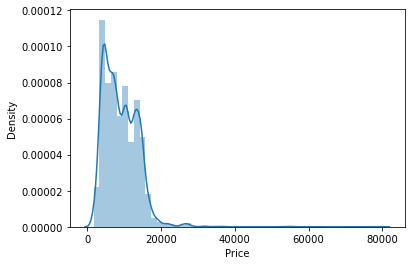

In [23]:
# distribution of the target column 
# right skewed distribution
# outliers present but not that significant , hence  
sns.distplot(y_train)

In [24]:
X_train.merge(y_train,on = X_train.index)

,key_0,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Total_Stops,total_duration_min,Price
0,0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,non-stop,170,3897.0
1,1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,2 stops,445,7662.0
2,2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,2 stops,1140,13882.0
3,3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,18:05,1 stop,325,6218.0
4,4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,16:50,1 stop,285,13302.0
...,...,...,...,...,...,...,...,...,...,...
7471,7471,Air India,2019-06-03,Delhi,Cochin,DEL → BOM → COK,10:00,1 stop,555,16439.0
7472,7472,Jet Airways,2019-05-21,Kolkata,Banglore,CCU → BOM → BLR,14:05,1 stop,510,14781.0
7473,7473,Jet Airways,2019-03-06,Delhi,Cochin,DEL → BOM → COK,19:45,1 stop,1010,10262.0
7474,7474,Jet Airways,2019-05-24,Kolkata,Banglore,CCU → BOM → BLR,14:05,1 stop,1690,10844.0


<AxesSubplot:xlabel='Price', ylabel='total_duration_min'>

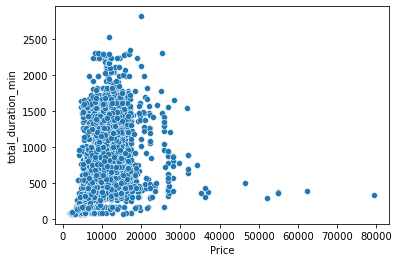

In [25]:
#No direct trend
sns.scatterplot(data=X_train.merge(y_train,on = X_train.index), x="Price", y="total_duration_min")

In [26]:
X_train.Route.nunique()

122

In [27]:
# cheapest / costliest --> flights per route 
# flights which provides services to most of the routes   
X_train.merge(y_train,on = X_train.index).groupby(['Route','Airline'])['Price'].agg(['min']).unstack().T.idxmin()

Route
BLR → AMD → DEL                          (min, Vistara)
BLR → BBI → DEL                        (min, Air India)
BLR → BDQ → DEL                      (min, Jet Airways)
BLR → BOM → AMD → DEL                  (min, Air India)
BLR → BOM → BHO → DEL                  (min, Air India)
BLR → BOM → DEL                           (min, IndiGo)
BLR → BOM → IDR → DEL                  (min, Air India)
BLR → BOM → IDR → GWL → DEL            (min, Air India)
BLR → BOM → JDH → DEL                (min, Jet Airways)
BLR → BOM → NAG → DEL                  (min, Air India)
BLR → BOM → UDR → DEL                  (min, Air India)
BLR → CCU → BBI → DEL                  (min, Air India)
BLR → CCU → BBI → HYD → DEL            (min, Air India)
BLR → CCU → DEL                        (min, Air India)
BLR → CCU → GAU → DEL                  (min, Air India)
BLR → COK → DEL                        (min, Air India)
BLR → DEL                               (min, SpiceJet)
BLR → GAU → DEL                        (mi

In [28]:
X_train.merge(y_train , on = X_train.index).groupby(['Total_Stops','Airline'])['Price'].agg(['min']).unstack().T.idxmin()

Total_Stops
1 stop         (min, IndiGo)
2 stops     (min, Air India)
3 stops     (min, Air India)
non-stop     (min, SpiceJet)
dtype: object

# Feature Engg

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7476 entries, 0 to 7475
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Airline             7476 non-null   object        
 1   Date_of_Journey     7476 non-null   datetime64[ns]
 2   Source              7476 non-null   object        
 3   Destination         7476 non-null   object        
 4   Route               7476 non-null   object        
 5   Dep_Time            7476 non-null   object        
 6   Total_Stops         7476 non-null   object        
 7   total_duration_min  7476 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 525.7+ KB


In [30]:
from sklearn.preprocessing import LabelEncoder
Airline_encoder = LabelEncoder()
Airline_encoder.fit(X_train['Airline'])
X_train['Airline_enc'] = Airline_encoder.transform(X_train['Airline'])

In [31]:
X_train[['Airline_enc','Airline']]

,Airline_enc,Airline
0,3,IndiGo
1,1,Air India
2,4,Jet Airways
3,3,IndiGo
4,3,IndiGo
...,...,...
7471,1,Air India
7472,4,Jet Airways
7473,4,Jet Airways
7474,4,Jet Airways


In [32]:
X_val['Airline_enc'] = Airline_encoder.transform(X_val['Airline'])
X_test['Airline_enc'] = Airline_encoder.transform(X_test['Airline'])

In [33]:
X_test[['Airline_enc','Airline']]

,Airline_enc,Airline
9079,8,Vistara
9080,7,SpiceJet
9081,5,Multiple carriers
9082,4,Jet Airways
9083,7,SpiceJet
...,...,...
10677,0,Air Asia
10678,1,Air India
10679,4,Jet Airways
10680,8,Vistara


In [34]:
X_train.drop(['Airline'], axis =1,inplace=True)
X_val.drop(['Airline'],axis=1 , inplace=True)
X_test.drop(['Airline'],axis=1 , inplace=True)


In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7476 entries, 0 to 7475
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_of_Journey     7476 non-null   datetime64[ns]
 1   Source              7476 non-null   object        
 2   Destination         7476 non-null   object        
 3   Route               7476 non-null   object        
 4   Dep_Time            7476 non-null   object        
 5   Total_Stops         7476 non-null   object        
 6   total_duration_min  7476 non-null   int64         
 7   Airline_enc         7476 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(5)
memory usage: 496.5+ KB


In [36]:
# function will delete a column from train , val and test
def thanos_snap(col ,traindf = X_train,valdf = X_val,testdf = X_test):
    traindf.drop(col, axis =1,inplace=True)
    valdf.drop(col,axis=1 , inplace=True)
    testdf.drop(col,axis=1 , inplace=True)

    return traindf,valdf ,testdf

In [37]:
# wrote a custom function to do a status check  on all the dataframes 
def status_check(traindf = X_train,valdf = X_val,testdf = X_test):
    print(traindf.info())
    print("****************************")
    print(traindf.shape,valdf.shape,testdf.shape)
    print("************Train Null Count****************")
    print(traindf.isna().sum())
    print("************Test Null Count ****************")
    print(testdf.isna().sum())    
    print("************Val Null Count ****************")
    print(valdf.isna().sum())    

In [38]:
#Date of journey
#0 --> Monday , 6 --> Sunday
X_train['day_of_week'] = X_train['Date_of_Journey'].dt.weekday 
X_val['day_of_week'] = X_val['Date_of_Journey'].dt.weekday 
X_test['day_of_week'] = X_test['Date_of_Journey'].dt.weekday     

In [39]:
#extract day,month and year 

X_train['day_of_Journey'] = X_train['Date_of_Journey'].dt.day
X_train['month_of_Journey'] = X_train['Date_of_Journey'].dt.month
X_train['year_of_Journey'] = X_train['Date_of_Journey'].dt.year

X_val['day_of_Journey'] = X_val['Date_of_Journey'].dt.day
X_val['month_of_Journey'] = X_val['Date_of_Journey'].dt.month
X_val['year_of_Journey'] = X_val['Date_of_Journey'].dt.year


X_test['day_of_Journey'] = X_test['Date_of_Journey'].dt.day
X_test['month_of_Journey'] = X_test['Date_of_Journey'].dt.month
X_test['year_of_Journey'] = X_test['Date_of_Journey'].dt.year

In [40]:
X_train ,X_val, X_test = thanos_snap(['Date_of_Journey'])

In [41]:
# label encode source and destination
source_encoder = LabelEncoder()
destination_encoder = LabelEncoder()

source_encoder.fit(X_train['Source'])
destination_encoder.fit(X_train['Destination'])

X_train['Source_enc'] = source_encoder.transform(X_train['Source'])
X_train['Destination_enc'] = destination_encoder.transform(X_train['Destination'])

X_val['Source_enc'] = source_encoder.transform(X_val['Source'])
X_val['Destination_enc'] = destination_encoder.transform(X_val['Destination'])

X_test['Source_enc'] = source_encoder.transform(X_test['Source'])
X_test['Destination_enc'] = destination_encoder.transform(X_test['Destination'])

In [42]:
X_train ,X_val, X_test = thanos_snap(['Source','Destination'])

In [43]:
# label enceode route as well
route_encoder = LabelEncoder()

route_encoder.fit(X_train['Route'])

X_train['Route_enc'] = route_encoder.transform(X_train['Route'])

In [44]:
#Error !!!!!: Since X_val new catagories of routes are seen hence we have to explicitly add them to class 
#X_val['Route'] = route_encoder.transform(X_val['Route'])

In [45]:
# finding what are the new catagories in the validation set
diff = set(X_val['Route'])-set(route_encoder.classes_)

# adding them to the classess variable // 
for items in diff:
    route_encoder.classes_ = np.append(route_encoder.classes_,items)


In [46]:
X_val['Route_enc'] = route_encoder.transform(X_val['Route'])

In [47]:
# doing same thing for test also

diff2 = set(X_test['Route'])-set(route_encoder.classes_)
for items in diff2:
    route_encoder.classes_ = np.append(route_encoder.classes_,items)


In [48]:
X_test['Route_enc'] = route_encoder.transform(X_test['Route'])

In [49]:
X_train ,X_val, X_test = thanos_snap(['Route'])

In [50]:
# splitting on the basis of ':' 
# use astype(int) to convert it into integer
X_train['Dep_Time'] = X_train['Dep_Time'].str.replace(':',"").astype(int)
X_val['Dep_Time'] = X_val['Dep_Time'].str.replace(':',"").astype(int)
X_test['Dep_Time'] = X_test['Dep_Time'].str.replace(':',"").astype(int)

In [51]:
status_check()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7476 entries, 0 to 7475
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Dep_Time            7476 non-null   int32 
 1   Total_Stops         7476 non-null   object
 2   total_duration_min  7476 non-null   int64 
 3   Airline_enc         7476 non-null   int32 
 4   day_of_week         7476 non-null   int64 
 5   day_of_Journey      7476 non-null   int64 
 6   month_of_Journey    7476 non-null   int64 
 7   year_of_Journey     7476 non-null   int64 
 8   Source_enc          7476 non-null   int32 
 9   Destination_enc     7476 non-null   int32 
 10  Route_enc           7476 non-null   int32 
dtypes: int32(5), int64(5), object(1)
memory usage: 554.9+ KB
None
****************************
(7476, 11) (1602, 11) (1603, 11)
************Train Null Count****************
Dep_Time              0
Total_Stops           0
total_duration_min    0
Airline_enc           0

In [52]:
# making our life easy only extracting the int from the Total_stops
X_train["Total_Stops"] = X_train["Total_Stops"].str.replace("non-","0 ").str.split(" ").str[0].astype(int)
X_val["Total_Stops"] = X_val["Total_Stops"].str.replace("non-","0 ").str.split(" ").str[0].astype(int)
X_test["Total_Stops"] = X_test["Total_Stops"].str.replace("non-","0 ").str.split(" ").str[0].astype(int)

# Feature Selection

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

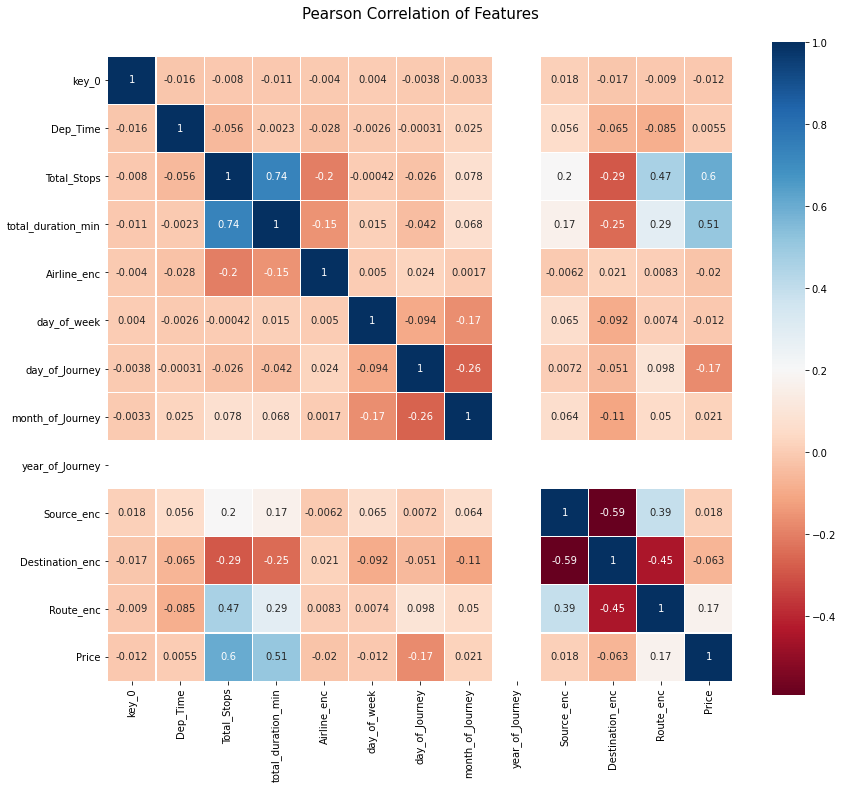

In [53]:
#Feature Selection

#corrmat = X_train.merge(y_train , on = X_train.index).corr()
# plt.subplots(figsize=(12,9))
# sns.heatmap(corrmat, vmax=0.9, square=True)


colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train.merge(y_train , on = X_train.index ).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [54]:
# here you can see year of journey is a constant column hence should be dropped 

In [55]:
# also since all the columns have been converted to int/ float , you can use variance threshold -- ;-D

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(0.8)
sel.fit(X_train)

VarianceThreshold(threshold=0.8)

In [56]:
sel.variances_

array([3.32452330e+05, 4.48921246e-01, 2.52301334e+05, 3.62683031e+00,
       3.39075516e+00, 7.73599744e+01, 8.88596122e+00, 0.00000000e+00,
       1.38977412e+00, 2.14058318e+00, 1.23641287e+03])

In [57]:
X_train,X_val ,X_test = thanos_snap(['year_of_Journey'])

In [58]:
status_check()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7476 entries, 0 to 7475
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Dep_Time            7476 non-null   int32
 1   Total_Stops         7476 non-null   int32
 2   total_duration_min  7476 non-null   int64
 3   Airline_enc         7476 non-null   int32
 4   day_of_week         7476 non-null   int64
 5   day_of_Journey      7476 non-null   int64
 6   month_of_Journey    7476 non-null   int64
 7   Source_enc          7476 non-null   int32
 8   Destination_enc     7476 non-null   int32
 9   Route_enc           7476 non-null   int32
dtypes: int32(6), int64(4)
memory usage: 467.2 KB
None
****************************
(7476, 10) (1602, 10) (1603, 10)
************Train Null Count****************
Dep_Time              0
Total_Stops           0
total_duration_min    0
Airline_enc           0
day_of_week           0
day_of_Journey        0
month_of_Journey      0

# Modelling 

#create a base model

In [59]:

from sklearn.linear_model import LinearRegression
base_model = LinearRegression()
base_model.fit(X_train, y_train)

LinearRegression()

In [60]:
y_predict = base_model.predict(X_val)

In [61]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_val, y_predict, squared=False)

3309.8956141041226

In [62]:
met = pd.DataFrame(zip(y_predict , y_test),columns=['Predicted','Actuals'])

In [63]:
(abs(met.Predicted-met.Actuals)/met.Actuals).mean()

0.6228731963181376

#Tree based model

In [64]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0 , max_depth=5)

In [65]:
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=0)

In [66]:
y_predict2 = regressor.predict(X_val)

In [67]:
mean_squared_error(y_val, y_predict2, squared=False)

2343.0470814980317

#Once you think you have good enough result do a prediction on the X_test set just to confirm that the model is not getting overfitted

In [68]:
y_predict_test = regressor.predict(X_test)
mean_squared_error(y_test, y_predict_test, squared=False)

3119.3308453049367

# The lost data 

so in this point we have :
 1. A model i.e regressor
 2. main_test
 3. some encoders to map i.e airline_enc etc

we have to predict the price using the model and fill it up in the price column
 


In [69]:
# see again price is all nan
main_test


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Total_Stops,total_duration_min,Price
10682,Jet Airways,06-06-2019,Delhi,Cochin,DEL → BOM → COK,17:30,1 stop,655,NaN
10683,IndiGo,12-05-2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,1 stop,240,NaN
10684,Jet Airways,21-05-2019,Delhi,Cochin,DEL → BOM → COK,19:15,1 stop,1425,NaN
10685,Multiple carriers,21-05-2019,Delhi,Cochin,DEL → BOM → COK,08:00,1 stop,780,NaN
10686,Air Asia,24-06-2019,Banglore,Delhi,BLR → DEL,23:55,non-stop,170,NaN
...,...,...,...,...,...,...,...,...,...
13347,Air India,06-06-2019,Kolkata,Banglore,CCU → DEL → BLR,20:30,1 stop,1435,NaN
13348,IndiGo,27-03-2019,Kolkata,Banglore,CCU → BLR,14:20,non-stop,155,NaN
13349,Jet Airways,06-03-2019,Delhi,Cochin,DEL → BOM → COK,21:50,1 stop,395,NaN
13350,Air India,06-03-2019,Delhi,Cochin,DEL → BOM → COK,04:00,1 stop,915,NaN


we have to bring the main_test in same format as that of the X_train
 1. Do same preprocessing steps
 2. Do same feature engg
 3. Do same feature selection
 4. fed to model and predict

why no EDA ? -- Becz EDA is done only on the train set
 

In [70]:
# Preprocessing 

#### Null / constant / duplicate drop same steps

In [71]:
main_test.isna().sum()

Airline                  0
Date_of_Journey          0
Source                   0
Destination              0
Route                    0
Dep_Time                 0
Total_Stops              0
total_duration_min       0
Price                 2670
dtype: int64

#### drop price column as we are going to predict that + its null

In [72]:
X_main_test = main_test.drop(['Price'],axis=1)
X_main_test

# ALSO LETS DROP PRICE FROM MAIN TEST ITSELF
main_test.drop(['Price'], inplace =True,axis=1)

In [73]:
X_main_test['Date_of_Journey'] = pd.to_datetime(X_main_test['Date_of_Journey'])

In [74]:
#Feature Engg

##To Remember exactly same set of feature even the column name should be same 

In [75]:
# Again new classed are there in the main_test set
temp = set(X_main_test['Airline'])-set(Airline_encoder.classes_)
for items in temp:
    Airline_encoder.classes_= np.append(Airline_encoder.classes_,items)

X_main_test['Airline_enc'] = Airline_encoder.transform(X_main_test['Airline'])

In [76]:
X_main_test['day_of_week'] = X_main_test['Date_of_Journey'].dt.weekday 
X_main_test['day_of_Journey'] = X_main_test['Date_of_Journey'].dt.day
X_main_test['month_of_Journey'] = X_main_test['Date_of_Journey'].dt.month
X_main_test['year_of_Journey'] = X_main_test['Date_of_Journey'].dt.year

In [77]:
X_main_test['Source_enc'] = source_encoder.transform(X_main_test['Source'])
X_main_test['Destination_enc'] = destination_encoder.transform(X_main_test['Destination'])


In [78]:
temp2 = set(X_main_test['Route'])-set(route_encoder.classes_)
for items in temp2:
    route_encoder.classes_= np.append(route_encoder.classes_,items)
    
X_main_test['Route_enc'] = route_encoder.transform(X_main_test['Route'])

In [79]:
X_main_test['Dep_Time'] = X_main_test['Dep_Time'].str.replace(':',"").astype(int)

In [80]:
X_main_test["Total_Stops"] = X_main_test["Total_Stops"].str.replace("non-","0 ").str.split(" ").str[0].astype(int)

In [81]:
X_main_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2670 entries, 10682 to 13351
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Airline             2670 non-null   object        
 1   Date_of_Journey     2670 non-null   datetime64[ns]
 2   Source              2670 non-null   object        
 3   Destination         2670 non-null   object        
 4   Route               2670 non-null   object        
 5   Dep_Time            2670 non-null   int32         
 6   Total_Stops         2670 non-null   int32         
 7   total_duration_min  2670 non-null   int64         
 8   Airline_enc         2670 non-null   int32         
 9   day_of_week         2670 non-null   int64         
 10  day_of_Journey      2670 non-null   int64         
 11  month_of_Journey    2670 non-null   int64         
 12  year_of_Journey     2670 non-null   int64         
 13  Source_enc          2670 non-null   int32  

In [82]:
# Deleteing the object/datetime counter parts

X_main_test.drop(['Airline','Date_of_Journey','Source','Destination','Route'],inplace =True ,axis=1)

In [83]:
X_main_test.columns

Index(['Dep_Time', 'Total_Stops', 'total_duration_min', 'Airline_enc',
       'day_of_week', 'day_of_Journey', 'month_of_Journey', 'year_of_Journey',
       'Source_enc', 'Destination_enc', 'Route_enc'],
      dtype='object')

In [84]:
X_train.columns

Index(['Dep_Time', 'Total_Stops', 'total_duration_min', 'Airline_enc',
       'day_of_week', 'day_of_Journey', 'month_of_Journey', 'Source_enc',
       'Destination_enc', 'Route_enc'],
      dtype='object')

In [85]:
# remove year_of_journey 

X_main_test.drop(['year_of_Journey'],inplace =True ,axis=1)

# END GAME

In [86]:
# PREDICT IT 

final_result = regressor.predict(X_main_test)

In [87]:
final_result = pd.Series(final_result,name='Price')

In [88]:
# resetting the index of main test so that we can merge price series with it
main_test.reset_index(drop=True,inplace=True)

In [89]:
Final = main_test.merge(final_result , on = X_main_test.index )
Final 

,key_0,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Total_Stops,total_duration_min,Price
0,10682,Jet Airways,06-06-2019,Delhi,Cochin,DEL → BOM → COK,17:30,1 stop,655,12463.063173
1,10683,IndiGo,12-05-2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,1 stop,240,5913.272512
2,10684,Jet Airways,21-05-2019,Delhi,Cochin,DEL → BOM → COK,19:15,1 stop,1425,12463.063173
3,10685,Multiple carriers,21-05-2019,Delhi,Cochin,DEL → BOM → COK,08:00,1 stop,780,9851.501722
4,10686,Air Asia,24-06-2019,Banglore,Delhi,BLR → DEL,23:55,non-stop,170,4681.839544
...,...,...,...,...,...,...,...,...,...,...
2665,13347,Air India,06-06-2019,Kolkata,Banglore,CCU → DEL → BLR,20:30,1 stop,1435,7867.000000
2666,13348,IndiGo,27-03-2019,Kolkata,Banglore,CCU → BLR,14:20,non-stop,155,4681.839544
2667,13349,Jet Airways,06-03-2019,Delhi,Cochin,DEL → BOM → COK,21:50,1 stop,395,15876.991968
2668,13350,Air India,06-03-2019,Delhi,Cochin,DEL → BOM → COK,04:00,1 stop,915,12843.463687


# Congratulations on predicting the price !!!!!!!!!!!!!

The END